In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style='whitegrid')

In [6]:
df = pd.read_excel('../data/Online Retail.xlsx')

df.shape

(541909, 8)

In [7]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55    17850.00  United Kingdom  
1 2010-12-01 08:26:00       3.39    17850.00  United Kingdom  
2 2010-12-01 08:26:00       2.75    17850.00  United Kingdom  
3 2010-12-01 08:26:00       3.39    17850.00  United Kingdom  
4 2010-12-01 08:26:00       3.39    17850.00  United Kingdom

In [8]:
df.dropna(subset=['CustomerID'], inplace=True)

df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

print("Cleaned dataset shape:", df.shape)


Cleaned dataset shape: (397884, 8)


In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

NOW = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days, 
    'InvoiceNo': 'nunique',                         
    'UnitPrice': lambda x: (x * df.loc[x.index, 'Quantity']).sum() 
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()


CustomerID  Recency  Frequency  Monetary
0    12346.00      326          1  77183.60
1    12347.00        2          7   4310.00
2    12348.00       75          4   1797.24
3    12349.00       19          1   1757.55
4    12350.00      310          1    334.40

In [10]:
from sklearn.preprocessing import StandardScaler
import numpy as np

rfm_log = rfm.copy()
rfm_log[['Recency', 'Frequency', 'Monetary']] = np.log1p(rfm_log[['Recency', 'Frequency', 'Monetary']])

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])


In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]


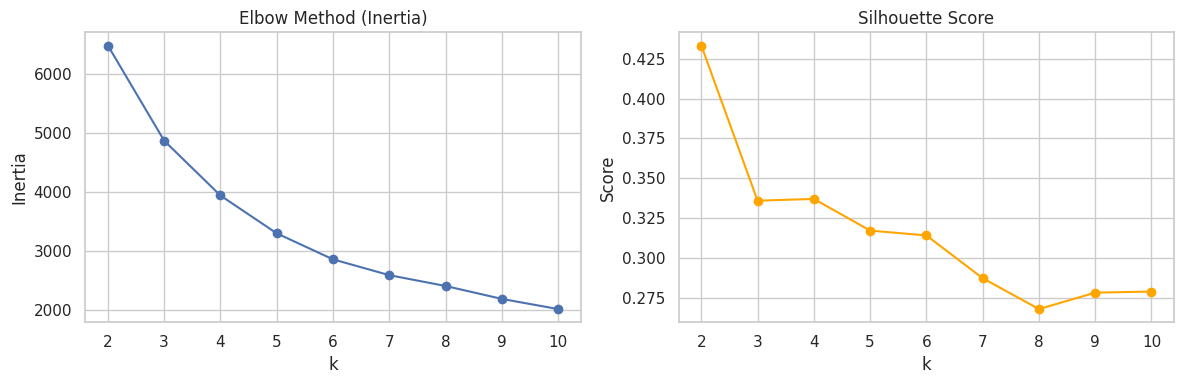

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)
    sil_scores.append(silhouette_score(rfm_scaled, model.labels_))


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('k'); plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_values, sil_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('k'); plt.ylabel('Score')
plt.savefig("plot_for_k.png")
plt.tight_layout()
plt.show()



In [13]:
# k=3
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['KMeansCluster'] = kmeans.fit_predict(rfm_scaled)

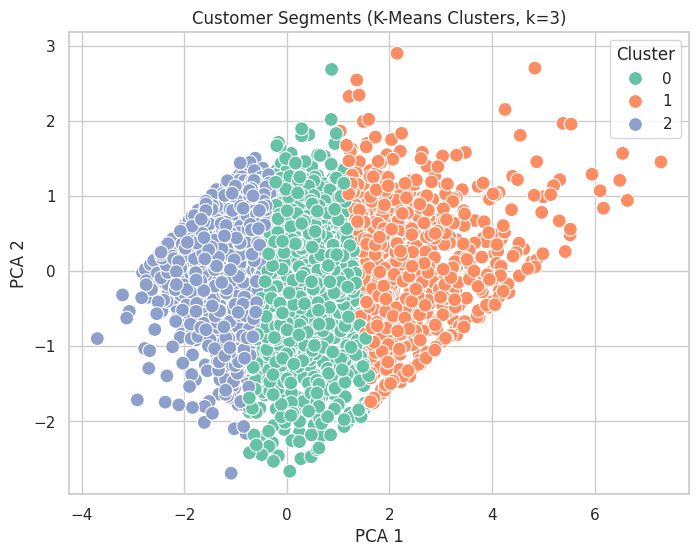

In [39]:

plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='KMeansCluster', palette='Set2', s=100)
plt.title('Customer Segments (K-Means Clusters, k=3)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.savefig("outputs/cluster_plots/pca_kmeans_clusters.png")
plt.show()

In [15]:
rfm.groupby('KMeansCluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)


Recency  Frequency  Monetary
KMeansCluster                              
0                44.50       3.40   1257.70
1                17.10      13.30   7865.60
2               167.60       1.30    361.50

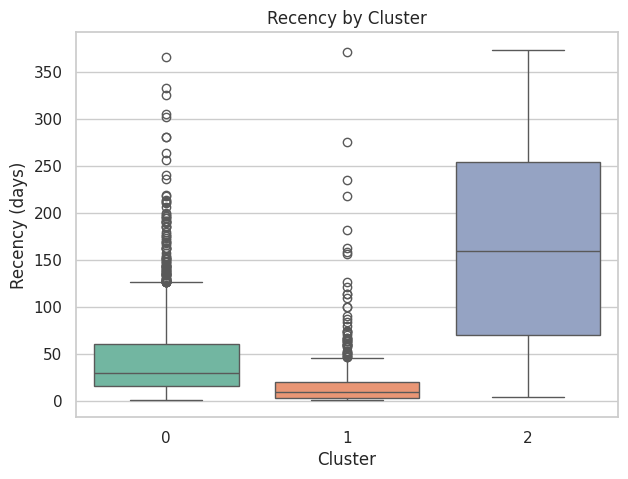

In [16]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=rfm, x='KMeansCluster', y='Recency',hue='KMeansCluster', palette='Set2', legend=False)
plt.title("Recency by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Recency (days)")
plt.show()


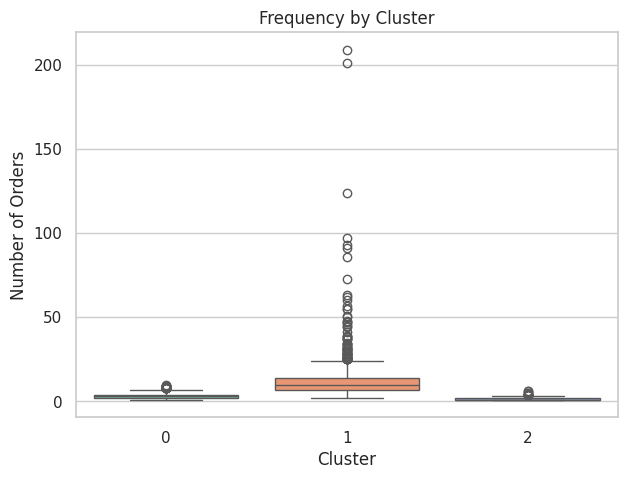

In [17]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=rfm, x='KMeansCluster', y='Frequency',hue='KMeansCluster', palette='Set2', legend=False)
plt.title("Frequency by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Orders")
plt.show()


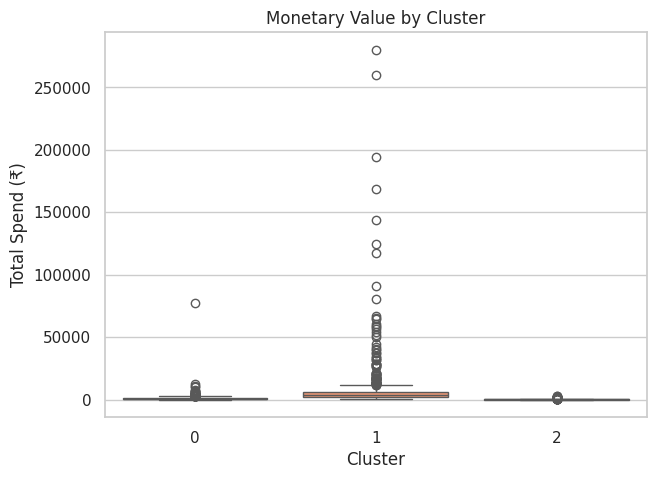

In [18]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=rfm, x='KMeansCluster', y='Monetary',hue='KMeansCluster', palette='Set2', legend=False)
plt.title("Monetary Value by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Total Spend (₹)")
plt.show()


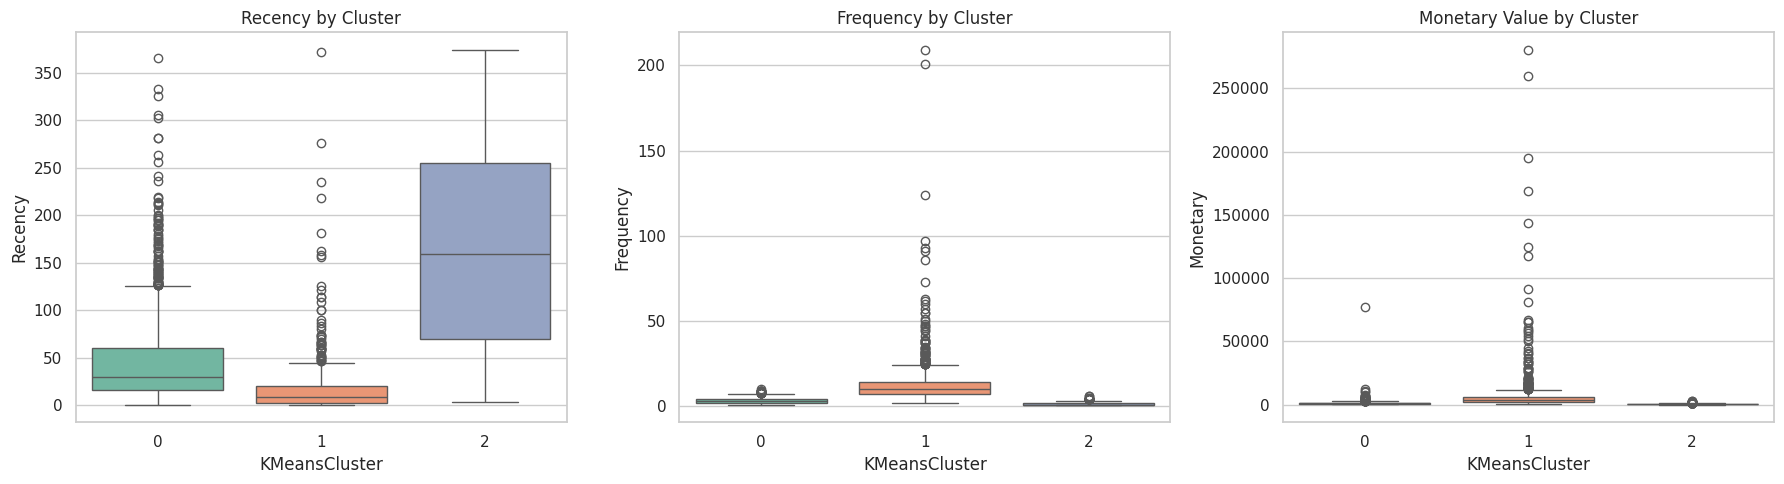

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=rfm, x='KMeansCluster', y='Recency', ax=axes[0], hue='KMeansCluster', palette='Set2', legend=False)
axes[0].set_title("Recency by Cluster")

sns.boxplot(data=rfm, x='KMeansCluster', y='Frequency', ax=axes[1], hue='KMeansCluster', palette='Set2', legend=False)
axes[1].set_title("Frequency by Cluster")

sns.boxplot(data=rfm, x='KMeansCluster', y='Monetary', ax=axes[2], hue='KMeansCluster', palette='Set2', legend=False)
axes[2].set_title("Monetary Value by Cluster")

plt.tight_layout()
plt.savefig("outputs/cluster_plots/rfm_kmeans_clusters_box.png")
plt.show()


In [20]:
df_mba = df.copy()

df_mba.dropna(subset=['CustomerID', 'Description'], inplace=True)

df_mba = df_mba[~df_mba['InvoiceNo'].astype(str).str.startswith('C')]

df_mba = df_mba[df_mba['Quantity'] > 0]


In [21]:
basket = df_mba.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

basket = (basket > 0).astype(int)
basket.head()


Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
InvoiceNo                                                                     
536365                                    0                               0   
536366                                    0                               0   
536367                                    0                               0   
536368                                    0                               0   
536369                                    0                               0   

Description   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK  \
InvoiceNo                                                       
536365                        0                             0   
536366                        0                             0   
536367                        0                             0   
536368                        0                             0   
536369                        0                             0   

Description   I LOVE LONDON MINI RUCKSACK   NINE DRAWER OFFICE TIDY  \
InvoiceNo                                                             
536365                                  0                         0   
536366                                  0                         0   
536367                                  0                         0   
536368                                  0                         0   
536369                                  0                         0   

Description   OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE  \
InvoiceNo                                                            
536365                                 0                         0   
536366                                 0                         0   
536367                                 0                         0   
536368                                 0                         0   
536369                                 0                         0   

Description   SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET  ...  \
InvoiceNo                                                               ...   
536365                                      0                        0  ...   
536366                                      0                        0  ...   
536367                                      0                        0  ...   
536368                                      0                        0  ...   
536369                                      0                        0  ...   

Description  ZINC STAR T-LIGHT HOLDER   ZINC SWEETHEART SOAP DISH  \
InvoiceNo                                                           
536365                               0                          0   
536366                               0                          0   
536367                               0                          0   
536368                               0                          0   
536369                               0                          0   

Description  ZINC SWEETHEART WIRE LETTER RACK  ZINC T-LIGHT HOLDER STAR LARGE  \
InvoiceNo                                                                       
536365                                      0                               0   
536366                                      0                               0   
536367                                      0                               0   
536368                                      0                               0   
536369                                      0                               0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
InvoiceNo                                                                       
536365                                     0                                0   
536366                                     0                                0   
536367                                     0                           

In [22]:
basket.shape

(18532, 3877)

In [23]:
from mlxtend.frequent_patterns import fpgrowth

basket = basket.astype(bool)
frequent_itemsets_fp = fpgrowth(basket, min_support=0.01, use_colnames=True)

frequent_itemsets_fp.sort_values(by='support', ascending=False).head(10)


support                              itemsets
0       0.11  (WHITE HANGING HEART T-LIGHT HOLDER)
253     0.09            (REGENCY CAKESTAND 3 TIER)
88      0.09             (JUMBO BAG RED RETROSPOT)
438     0.07                       (PARTY BUNTING)
7       0.07       (ASSORTED COLOUR BIRD ORNAMENT)
41      0.07             (LUNCH BAG RED RETROSPOT)
465     0.06   (SET OF 3 CAKE TINS PANTRY DESIGN )
18      0.06                             (POSTAGE)
157     0.06             (LUNCH BAG  BLACK SKULL.)
42      0.06     (PACK OF 72 RETROSPOT CAKE CASES)

In [24]:
from mlxtend.frequent_patterns import association_rules

rules_fp = association_rules(frequent_itemsets_fp, metric='lift', min_threshold=1)

rules_fp = rules_fp.sort_values(by='lift', ascending=False)
rules_fp.head(10)


antecedents  \
888                           (REGENCY TEA PLATE PINK)   
889                         (REGENCY TEA PLATE GREEN )   
595                    (POPPY'S PLAYHOUSE LIVINGROOM )   
590  (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...   
884                         (REGENCY SUGAR BOWL GREEN)   
885                           (REGENCY MILK JUG PINK )   
592  (POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...   
593                       (POPPY'S PLAYHOUSE BEDROOM )   
890                         (REGENCY TEA PLATE ROSES )   
891                           (REGENCY TEA PLATE PINK)   

                                           consequents  antecedent support  \
888                         (REGENCY TEA PLATE GREEN )                0.01   
889                           (REGENCY TEA PLATE PINK)                0.01   
595  (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...                0.01   
590                    (POPPY'S PLAYHOUSE LIVINGROOM )                0.01   
884                           (REGENCY MILK JUG PINK )                0.01   
885                         (REGENCY SUGAR BOWL GREEN)                0.01   
592                       (POPPY'S PLAYHOUSE BEDROOM )                0.01   
593  (POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...                0.02   
890                           (REGENCY TEA PLATE PINK)                0.02   
891                         (REGENCY TEA PLATE ROSES )                0.01   

     consequent support  support  confidence  lift  representativity  \
888                0.01     0.01        0.90 61.90              1.00   
889                0.01     0.01        0.75 61.90              1.00   
595                0.01     0.01        0.74 53.85              1.00   
590                0.01     0.01        0.73 53.85              1.00   
884                0.01     0.01        0.77 52.37              1.00   
885                0.01     0.01        0.76 52.37              1.00   
592                0.02     0.01        0.87 50.74              1.00   
593                0.01     0.01        0.59 50.74              1.00   
890                0.01     0.01        0.60 49.69              1.00   
891                0.02     0.01        0.88 49.69              1.00   

     leverage  conviction  zhangs_metric  jaccard  certainty  kulczynski  
888      0.01       10.03           1.00     0.69       0.90        0.82  
889      0.01        3.92           1.00     0.69       0.75        0.82  
595      0.01        3.77           0.99     0.58       0.73        0.74  
590      0.01        3.68           1.00     0.58       0.73        0.74  
884      0.01        4.26           1.00     0.62       0.77        0.76  
885      0.01        4.06           1.00     0.62       0.75        0.76  
592      0.01        7.29           0.99     0.54       0.86        0.73  
593      0.01        2.40           1.00     0.54       0.58        0.73  
890      0.01        2.47           1.00     0.55       0.60        0.74  
891      0.01        8.15           0.99     0.55       0.88        0.74

In [29]:
strong_rules_fp = rules_fp[(rules_fp['confidence'] >= 0.5) & (rules_fp['lift'] >= 1.2)]
strong_rules_fp.head(10)



antecedents  \
888                           (REGENCY TEA PLATE PINK)   
889                         (REGENCY TEA PLATE GREEN )   
595                    (POPPY'S PLAYHOUSE LIVINGROOM )   
590  (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...   
884                         (REGENCY SUGAR BOWL GREEN)   
885                           (REGENCY MILK JUG PINK )   
592  (POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...   
593                       (POPPY'S PLAYHOUSE BEDROOM )   
890                         (REGENCY TEA PLATE ROSES )   
891                           (REGENCY TEA PLATE PINK)   

                                           consequents  antecedent support  \
888                         (REGENCY TEA PLATE GREEN )                0.01   
889                           (REGENCY TEA PLATE PINK)                0.01   
595  (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...                0.01   
590                    (POPPY'S PLAYHOUSE LIVINGROOM )                0.01   
884                           (REGENCY MILK JUG PINK )                0.01   
885                         (REGENCY SUGAR BOWL GREEN)                0.01   
592                       (POPPY'S PLAYHOUSE BEDROOM )                0.01   
593  (POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...                0.02   
890                           (REGENCY TEA PLATE PINK)                0.02   
891                         (REGENCY TEA PLATE ROSES )                0.01   

     consequent support  support  confidence  lift  representativity  \
888                0.01     0.01        0.90 61.90              1.00   
889                0.01     0.01        0.75 61.90              1.00   
595                0.01     0.01        0.74 53.85              1.00   
590                0.01     0.01        0.73 53.85              1.00   
884                0.01     0.01        0.77 52.37              1.00   
885                0.01     0.01        0.76 52.37              1.00   
592                0.02     0.01        0.87 50.74              1.00   
593                0.01     0.01        0.59 50.74              1.00   
890                0.01     0.01        0.60 49.69              1.00   
891                0.02     0.01        0.88 49.69              1.00   

     leverage  conviction  zhangs_metric  jaccard  certainty  kulczynski  
888      0.01       10.03           1.00     0.69       0.90        0.82  
889      0.01        3.92           1.00     0.69       0.75        0.82  
595      0.01        3.77           0.99     0.58       0.73        0.74  
590      0.01        3.68           1.00     0.58       0.73        0.74  
884      0.01        4.26           1.00     0.62       0.77        0.76  
885      0.01        4.06           1.00     0.62       0.75        0.76  
592      0.01        7.29           0.99     0.54       0.86        0.73  
593      0.01        2.40           1.00     0.54       0.58        0.73  
890      0.01        2.47           1.00     0.55       0.60        0.74  
891      0.01        8.15           0.99     0.55       0.88        0.74

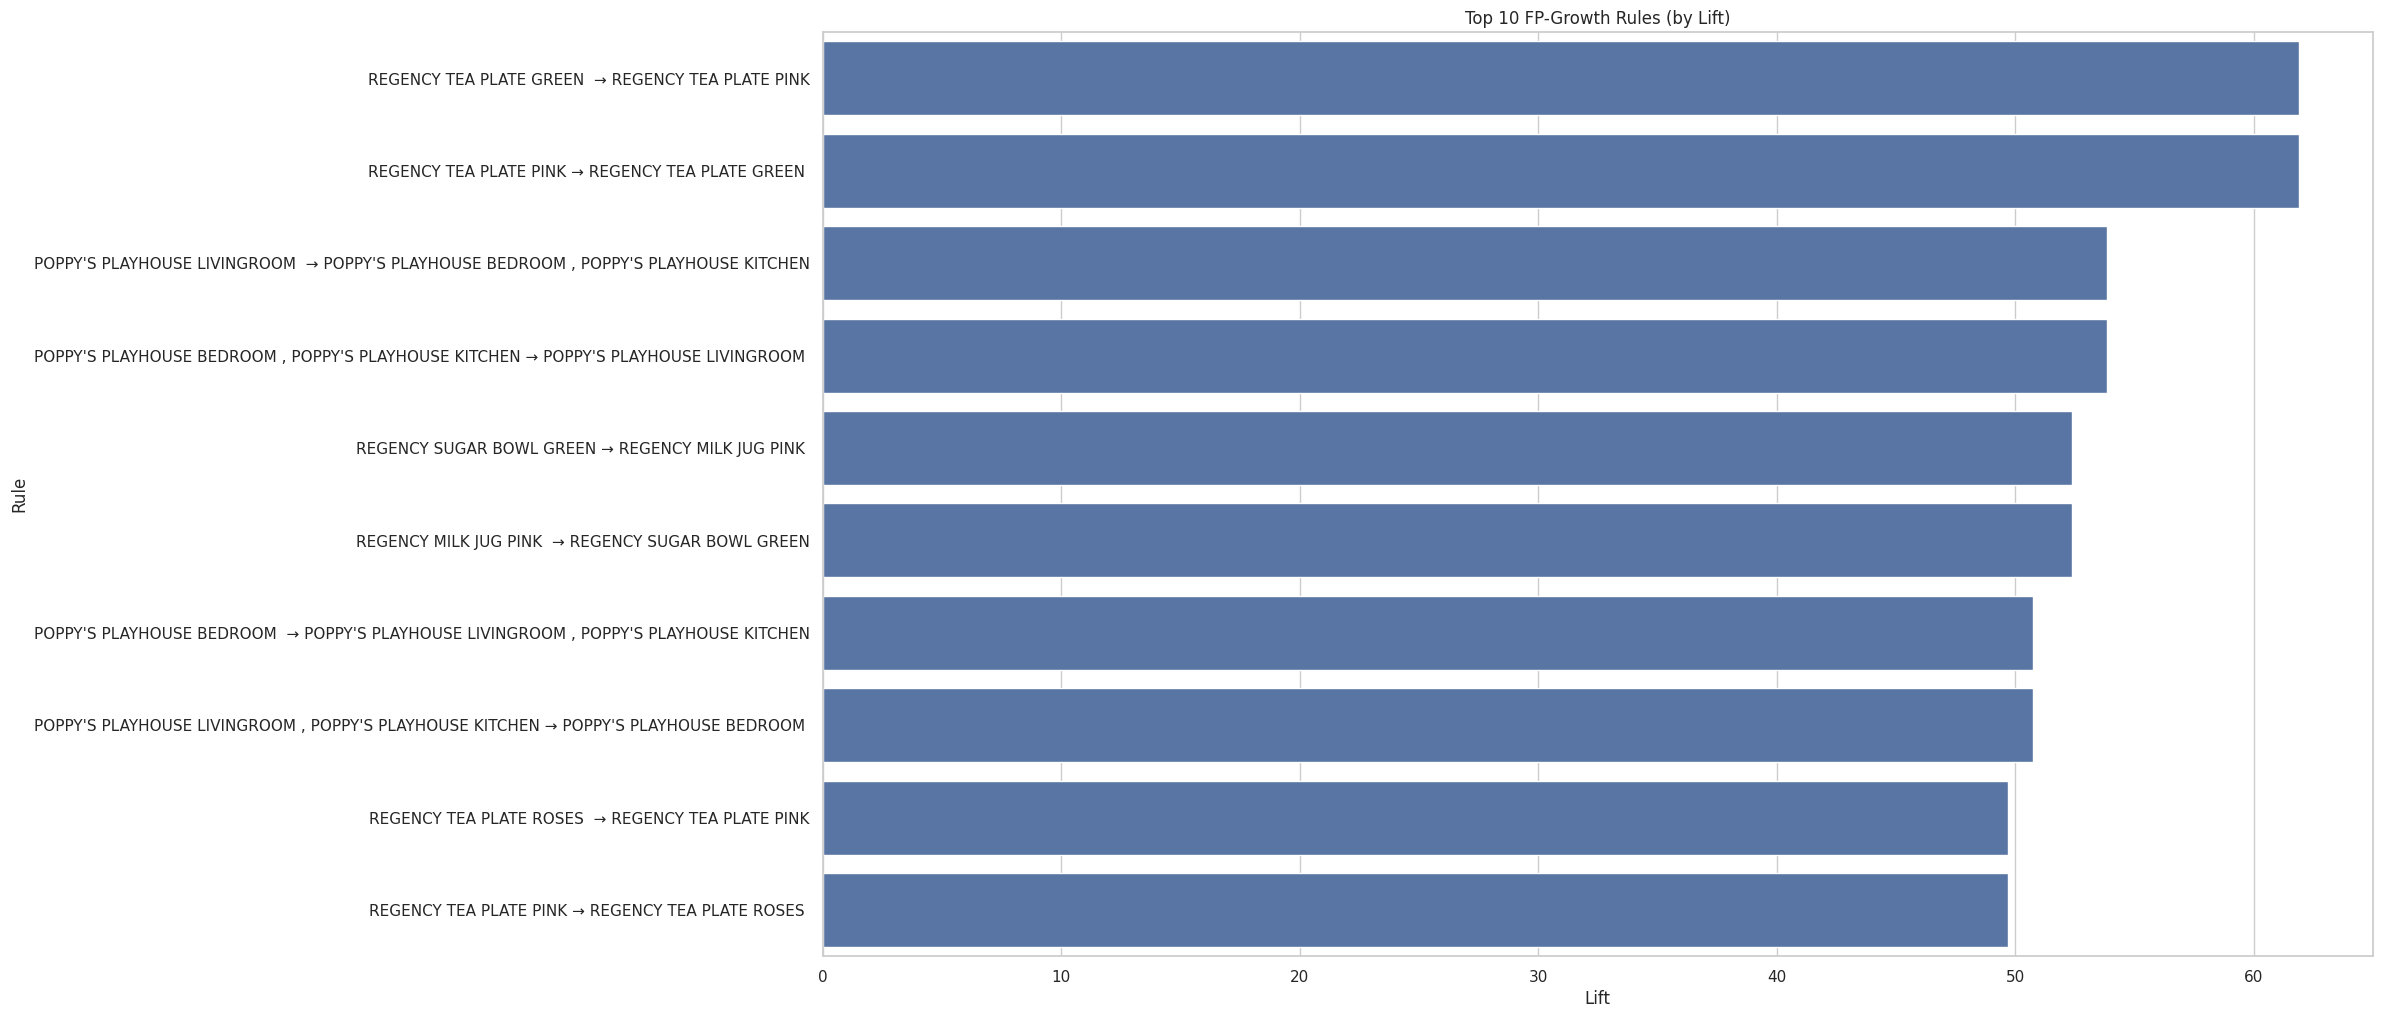

In [132]:
top_fp_rules = strong_rules_fp.nlargest(10, 'lift')

plt.figure(figsize=(20, 12))
sns.barplot(
    x='lift',
    y = top_fp_rules['antecedents'].apply(lambda x: ', '.join(list(x))) + " → " + \
    top_fp_rules['consequents'].apply(lambda x: ', '.join(list(x))),
    data=top_fp_rules
)
plt.title("Top 10 FP-Growth Rules (by Lift)")
plt.xlabel("Lift")
plt.ylabel("Rule")
# plt.tight_layout()
plt.show()


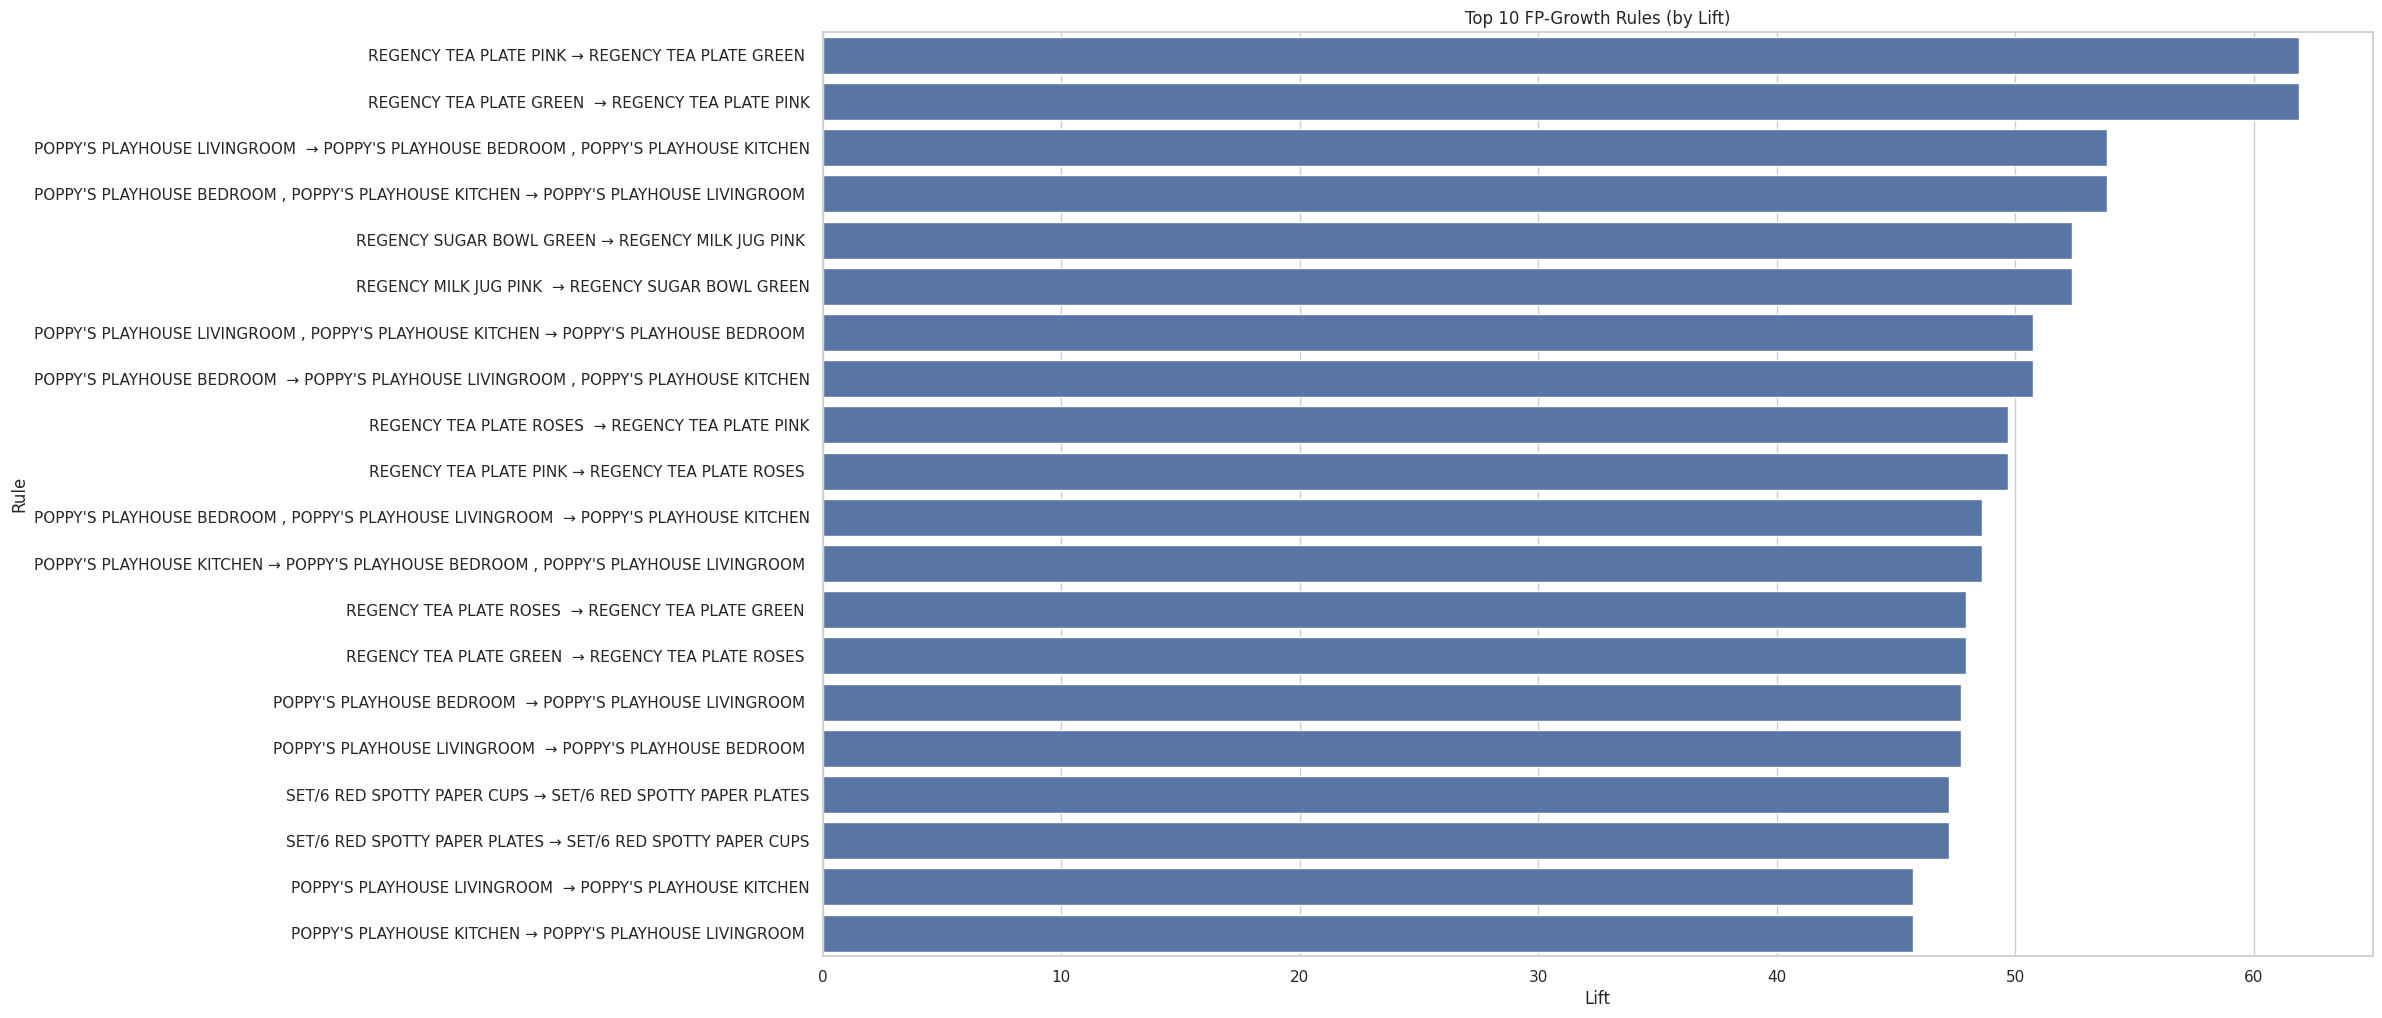

In [30]:
top_fp_rules = strong_rules_fp.nlargest(20, 'lift')

plt.figure(figsize=(20, 12))
sns.barplot(
    x='lift',
    y = top_fp_rules['antecedents'].apply(lambda x: ', '.join(list(x))) + " → " + \
    top_fp_rules['consequents'].apply(lambda x: ', '.join(list(x))),
    data=top_fp_rules
)
plt.title("Top 10 FP-Growth Rules (by Lift)")
plt.xlabel("Lift")
plt.ylabel("Rule")
# plt.tight_layout()
plt.show()


In [31]:
cluster_labels = {
    1: "VIP",        # High-value, frequent, recent
    0: "Moderate",   # Medium-value, active
    2: "Churned"     # Inactive or low-value
}

rfm['Segment'] = rfm['KMeansCluster'].map(cluster_labels)

print(rfm[['CustomerID', 'Segment']].head())

   CustomerID   Segment
0    12346.00  Moderate
1    12347.00       VIP
2    12348.00  Moderate
3    12349.00  Moderate
4    12350.00   Churned


In [44]:
rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().to_csv("outputs/summary/rfm_cluster_summary.csv")

In [47]:
df_segmented = df.merge(rfm[['CustomerID', 'Segment']], left_on='CustomerID', right_on='CustomerID')

top_items_by_segment = (
    df_segmented.groupby(['Segment', 'Description'])['Quantity']
    .sum()
    .reset_index()
    .sort_values(['Segment', 'Quantity'], ascending=[True, False])
)
top_items_by_segment.to_csv("outputs/summary/items_by_segment.csv")

top_items_by_segment.groupby('Segment').head(5)


Segment                         Description  Quantity
3231    Churned   WORLD WAR 2 GLIDERS ASSTD DESIGNS      6300
2782    Churned                SMALL POPCORN HOLDER      4727
197     Churned           ASSORTED COLOURS SILK FAN      3620
3157    Churned  WHITE HANGING HEART T-LIGHT HOLDER      2767
1923    Churned     PACK OF 72 RETROSPOT CAKE CASES      2516
5113   Moderate      MEDIUM CERAMIC TOP STORAGE JAR     74916
6243   Moderate         SMALL CHINESE STYLE SCISSOR     12731
6748   Moderate   WORLD WAR 2 GLIDERS ASSTD DESIGNS     11657
3504   Moderate       ASSORTED COLOUR BIRD ORNAMENT      8964
4896   Moderate             JUMBO BAG RED RETROSPOT      8472
9020        VIP         PAPER CRAFT , LITTLE BIRDIE     80995
10426       VIP   WORLD WAR 2 GLIDERS ASSTD DESIGNS     36458
8491        VIP             JUMBO BAG RED RETROSPOT     35755
10344       VIP  WHITE HANGING HEART T-LIGHT HOLDER     27560
9282        VIP                      POPCORN HOLDER     26281

In [33]:
print(df_segmented[['CustomerID', 'InvoiceNo', 'Segment']].head())

   CustomerID InvoiceNo Segment
0    17850.00    536365     VIP
1    17850.00    536365     VIP
2    17850.00    536365     VIP
3    17850.00    536365     VIP
4    17850.00    536365     VIP


In [34]:
df_segmented = df.merge(
    rfm[['CustomerID', 'Segment']],
    left_on='CustomerID',
    right_on='CustomerID',
    how='inner'
)


In [35]:
top_items_by_segment = (
    df_segmented.groupby(['Segment', 'Description'])['Quantity']
    .sum()
    .reset_index()
    .sort_values(['Segment', 'Quantity'], ascending=[True, False])
)

In [36]:
top_items_by_segment.groupby('Segment').head(5)

Segment                         Description  Quantity
3231    Churned   WORLD WAR 2 GLIDERS ASSTD DESIGNS      6300
2782    Churned                SMALL POPCORN HOLDER      4727
197     Churned           ASSORTED COLOURS SILK FAN      3620
3157    Churned  WHITE HANGING HEART T-LIGHT HOLDER      2767
1923    Churned     PACK OF 72 RETROSPOT CAKE CASES      2516
5113   Moderate      MEDIUM CERAMIC TOP STORAGE JAR     74916
6243   Moderate         SMALL CHINESE STYLE SCISSOR     12731
6748   Moderate   WORLD WAR 2 GLIDERS ASSTD DESIGNS     11657
3504   Moderate       ASSORTED COLOUR BIRD ORNAMENT      8964
4896   Moderate             JUMBO BAG RED RETROSPOT      8472
9020        VIP         PAPER CRAFT , LITTLE BIRDIE     80995
10426       VIP   WORLD WAR 2 GLIDERS ASSTD DESIGNS     36458
8491        VIP             JUMBO BAG RED RETROSPOT     35755
10344       VIP  WHITE HANGING HEART T-LIGHT HOLDER     27560
9282        VIP                      POPCORN HOLDER     26281

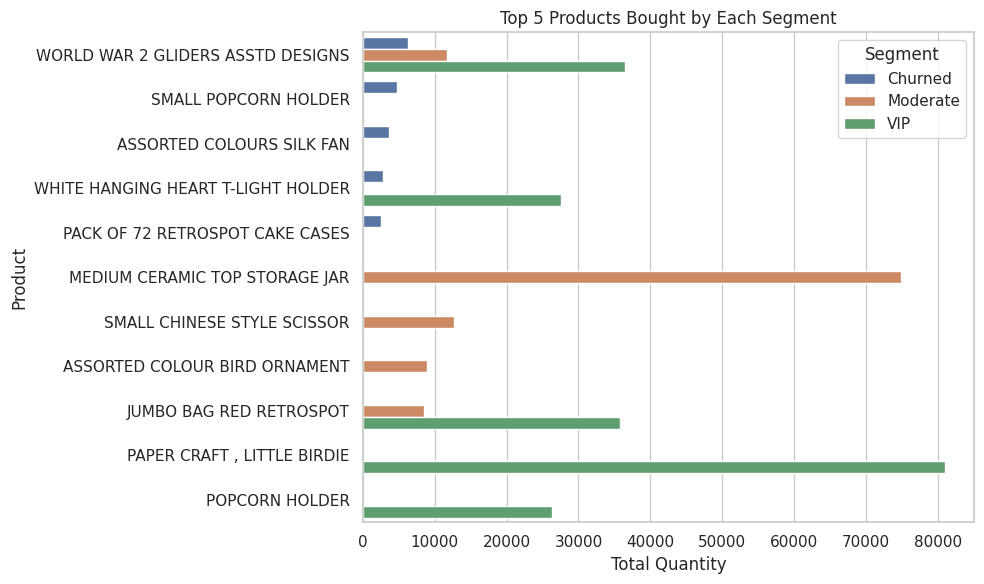

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

top5 = top_items_by_segment.groupby('Segment').head(5)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top5,
    x='Quantity',
    y='Description',
    hue='Segment'
)
plt.title("Top 5 Products Bought by Each Segment")
plt.xlabel("Total Quantity")
plt.ylabel("Product")
plt.legend(title='Segment')
plt.tight_layout()
plt.show()
